# RNN을 이용한 SMS Spam 분류
- 캐글에서 제공하는 [스팸메일 데이터](https://www.kaggle.com/uciml/sms-spam-collection-dataset)

### 한글 폰트 사용

In [ ]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq

Selecting previously unselected package fonts-nanum.
(Reading database ... 146442 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


In [ ]:
# 설치뒤 font-manager reduild
import matplotlib.font_manager as fm
fm._rebuild()

또는   
!sudo apt-get install -y fonts-nanum  
!sudo fc-cache -fv  
!rm ~/.cache/matplotlib -rf  

## Colab 런타임 다시 시작

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', family='NanumGothic')

In [ ]:
seed = 2021
np.random.seed(seed)
tf.random.set_seed(seed)

## 파일 업로드

In [ ]:
from google.colab import files

uploaded = files.upload()
filename = list(uploaded.keys())[0]

Saving spam.csv to spam.csv


In [ ]:
df=pd.read_csv(filename, encoding='latin1')
df.head(2)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN


## 전처리

In [ ]:
del df['Unnamed: 2']
del df['Unnamed: 3']
del df['Unnamed: 4']
df['v1'] = df['v1'].replace(['ham','spam'],[0,1]) #햄은0으로 스팸은1로 또는 LabelEncoding쓰면 됨
df.head(3)

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...


In [ ]:
df.info() #non-null나오니까 null널검사할필요없음.... df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   int64 
 1   v2      5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [ ]:
# 데이터 중복이 있는지 확인
df['v2'].nunique()
#5169  총5572인데 5169유니크하면 나머지는중복이라는뜻;

5169

In [ ]:
# 데이터 중복 제거
df = df.drop_duplicates('v2', keep='first')

In [ ]:
df.groupby('v1').size()

v1
0    4516
1     653
dtype: int64

In [ ]:
X_data = df['v2'].values
y_data = df['v1'].values
print('메일 본문의 개수:', len(X_data))
print('레이블의 개수:', len(y_data)) 
#메일 본문의 개수: 5169
#레이블의 개수: 5169

메일 본문의 개수: 5169
레이블의 개수: 5169


In [ ]:
# 단어 집합(vocabulary)을 만들고 크기를 확인 
t = Tokenizer()
t.fit_on_texts(X_data) # 5169개의 행을 가진 X의 각 행에 토큰화를 수행
sequences = t.texts_to_sequences(X_data) # 단어를 숫자값, 인덱스로 변환하여 저장
vocab_size = len(t.word_index) + 1
print('단어 집합의 크기 : %d' % vocab_size)
#8921 (X_data 원본데이터) 이게더좋다는거...;;

단어 집합의 크기 : 8921


### 전체 데이터셋의 길이를 임의의 숫자 100에 맞춤

In [ ]:
X_data = sequences
data = pad_sequences(X_data, maxlen=100) #뒤에 0를 채우기
data.shape
#(5169, 100)

(5169, 100)

In [ ]:
# 테스트용 데이터 20% 분리
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
    train_test_split(data, y_data, stratify=y_data, test_size=0.2, random_state=seed)

In [ ]:
X_train.shape, X_test.shape
#((4135, 100), (1034, 100))

((4135, 100), (1034, 100))

## 2. 모델 정의/설정/학습

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, SimpleRNN

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 32)) # 임베딩 벡터의 차원은 32
model.add(SimpleRNN(32))             # RNN 셀의 hidden_size는 32
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          285472    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 287,585
Trainable params: 287,585
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop', 
              metrics=['accuracy'])

In [ ]:
# 훈련용 데이터 중에서 20%는 검증 데이터로 사용
history = model.fit(X_train, y_train, epochs=10, 
                    batch_size=60, validation_split=0.2)
#val_loss가 가장작은녀석.....은 중간에 껴있다. 하지만 충분이 정확하기때문에 ㅋ.ㅋ

Epoch 1/10
56/56 [==============================] - 7s 78ms/step - loss: 0.4403 - accuracy: 0.8517 - val_loss: 0.2390 - val_accuracy: 0.9033
Epoch 2/10
56/56 [==============================] - 4s 73ms/step - loss: 0.1238 - accuracy: 0.9712 - val_loss: 0.0715 - val_accuracy: 0.9843
Epoch 3/10
56/56 [==============================] - 4s 72ms/step - loss: 0.1308 - accuracy: 0.9458 - val_loss: 0.0640 - val_accuracy: 0.9855
Epoch 4/10
56/56 [==============================] - 4s 73ms/step - loss: 0.0397 - accuracy: 0.9899 - val_loss: 0.0638 - val_accuracy: 0.9819
Epoch 5/10
56/56 [==============================] - 4s 71ms/step - loss: 0.0214 - accuracy: 0.9951 - val_loss: 0.0734 - val_accuracy: 0.9746
Epoch 6/10
56/56 [==============================] - 4s 72ms/step - loss: 0.0146 - accuracy: 0.9975 - val_loss: 0.0652 - val_accuracy: 0.9831
Epoch 7/10
56/56 [==============================] - 4s 77ms/step - loss: 0.0067 - accuracy: 0.9991 - val_loss: 0.0736 - val_accuracy: 0.9831
Epoch 8/10
56

In [ ]:
# 테스트 정확도
acc = model.evaluate(X_test, y_test, verbose=2)[1]
print(f"Accuracy:{acc:.4f}")
#Accuracy:0.9807

33/33 - 0s - loss: 0.0618 - accuracy: 0.9807
Accuracy:0.9807


findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


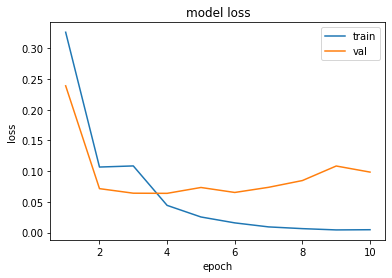

In [ ]:
epochs = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()